<a href="https://colab.research.google.com/github/syb0228/kaggle-titanic/blob/main/Kaggle_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 load
import pandas as pd
import numpy as np
import re
import sklearn
# boosted tree learning model
import xgboost as xgb

# Seaborn plotting package
import seaborn as sns # plot heatmaps # Pairplots
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Random Forest, Ada Boost, Gradient Boosting, Extra Trees
# 5가지 기본 모델을 Stacking에 사용
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# 트레이닝 및 테스트 데이터 셋 로드
train = pd.read_csv('/gdrive/My Drive/train.csv')
test = pd.read_csv('/gdrive/My Drive/test.csv')

# 편의를 위해 승객 ID 저장
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [ ]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

   Sex  Survived
0    0  0.742038
1    1  0.188908


In [ ]:
full_data = [train, test]

# Some features
# 승객 이름의 길이를 알려줌 -> Name_length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 승객이 타이타닉에 객실을 가지고 있는지 여부를 알려줌 -> Has_Cabin
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [ ]:
# Feature engineering
# siblings, spouse, children, parents 수를 이용해서 FamilySize라는 새로운 feature를 만듦
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # 자기 자신 포함

print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [ ]:
# 가족들 없이 혼자 탑승한 승객인지 아닌지 판단하여 새로운 IsAlone feature로 분류 
for dataset in full_data:
    dataset['IsAlone'] = 0 # 가족과 함께 탑승
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1 # 혼자 탑승

print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [ ]:
# 어느 곳에서 배를 탔는지를 나타내는 Embarked feature
# Embarked feature에 있는 결측값에 가장 많이 발생하는 값인 'S'를 채워넣음
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [ ]:
# 운임도 일부 결측값을 갖고 있으므로 중앙 값으로 대체해줌
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
# 해당 Fare feature를 4가지 범위로 분류해서 새로운 CategoricalFare feature 만들기
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [ ]:
# CategoricalAge feature에는 많은 결측값이 있음
# (평균-표준)과 (평균+표준) 사이의 난수 생성
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
# age를 5개의 범위로 분류해서 새로운 CategoricalAge feature 만들기
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.478632
1   (16.0, 32.0]  0.355556
2   (32.0, 48.0]  0.389344
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


In [ ]:
# 승객 이름에서 title를 추출하는 함수 정의
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# 승객 이름의 title를 포함하는 새로운 Title feature를 만든다.
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [ ]:
# 일반적이지 않은 모든 title를 하나의 단일 그룹 "Rare"로 묶음
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [ ]:
# Data Cleaning
# 데이터를 정리하고 features를 ML model에 입력하기 적합한 형식의 숫자 값으로 매핑
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [ ]:
# Feature 선택
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


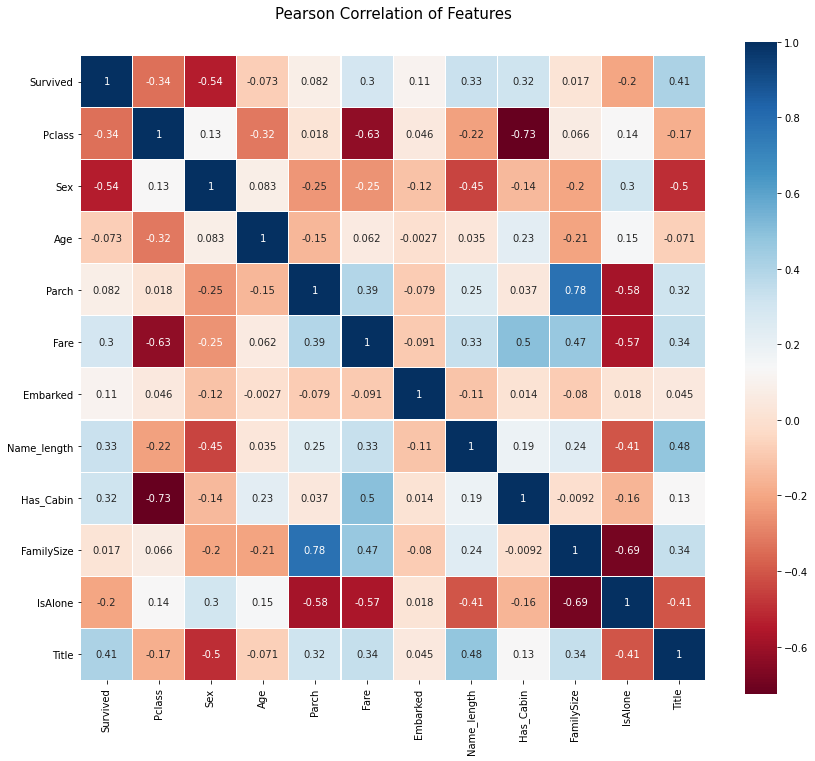

In [ ]:
# Pearson Correlation Heatmap
# 하나의 feature가 다음 feature와 어떻게 연관되어 있는지 확인

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

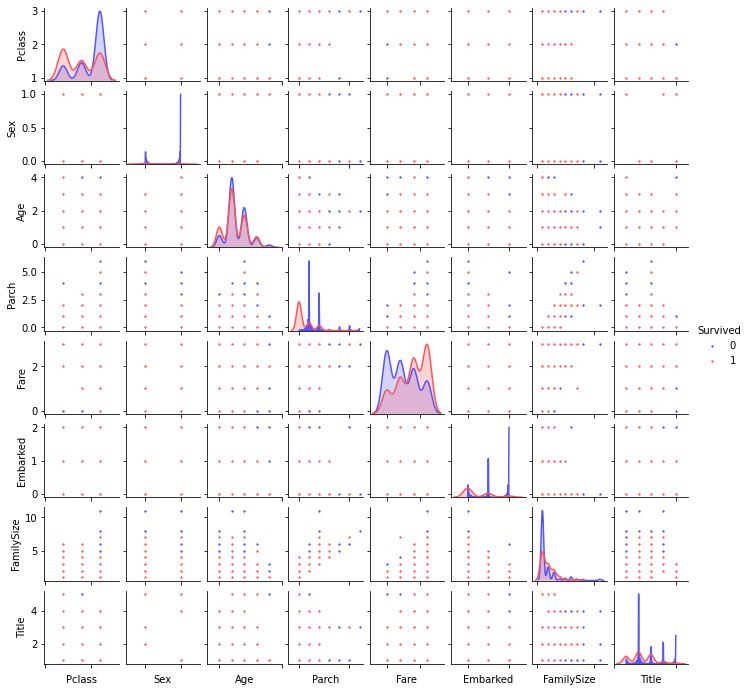

In [ ]:
# Pairplots
# 하나의 feature에서 다른 지점으로의 데이터 분포를 관찰하기 위해 pairplots을 생성

g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models

In [ ]:
# Stacking ensemble 만들기

# useful parameters
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# 모든 Sklearn classifier에 공통적인 내장 메소드(train, predict, fit)를 확장
# 동일한 메소드를 5번 작성할 필요가 없어져서 중복성이 줄어듦
class SklearnHelper(object):
    # class의 기본 생성자를 호출하기 위한 Python standard
    # 분류기를 만들기 위해 clf, seed, params의 매개 변수를 제공해야함
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [ ]:
# Out-of-Fold Predictions
# 예측 결과를 생성하는 함수

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [ ]:
# Base First-Level Models
# n_jobs : 훈련 과정에 사용 된 코어 수 (-1이면 모든 코어가 사용됨)
# n_estimators : 학습 모델의 분류 트리 수
# max_depth : 트리의 최대 깊이 또는 노드 확장 정도 (너무 높게 설정하면 overfitting 위험)
# verbose : 학습 과정에서 텍스트를 출력할지 여부를 제어 (값이 0이면 모든 텍스트가 억제, 3이면 반복할 때마다 출력)

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
# SklearnHelper 클래스를 통해 5가지 학습 모델을 나타내는 5개의 객체 생성 

rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# 분류기에 입력할 수 있도록 train, test 및 target dataframes의 Numpy 배열을 만듦
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # train data의 Numpy 배열 생성
x_test = test.values # test data의 Numpy 배열 생성

In [ ]:
# Out-of-Fold predictions 함수를 사용하여 first level 예측을 생성
# Out-of-Fold train을 만들고 예측을 테스트
# 예측 결과는 새로운 features로 사용됨

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [ ]:
# 다른 분류기에서 생성된 feature의 중요도 반환

rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12484231 0.19821376 0.03367174 0.02070144 0.07185823 0.02410997
 0.10937404 0.06589171 0.06661919 0.01360474 0.27111288]
[0.11975572 0.37673288 0.0307901  0.01638832 0.05581403 0.02757279
 0.04808774 0.08437986 0.04406429 0.0220463  0.17436795]
[0.03  0.01  0.018 0.068 0.034 0.008 0.692 0.012 0.056 0.002 0.07 ]
[0.08428805 0.01493879 0.05540284 0.01320267 0.05430635 0.02449896
 0.17364497 0.0380357  0.10788273 0.00706549 0.42673345]


In [ ]:
cols = train.columns.values
# features가 있는 데이터 프레임 생성
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [ ]:
# 모든 features 중요도의 평균을 계산하여 feature importance dataframe에 새로운 열로 저장

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


In [ ]:
# first level output에서 second level 예측
# 새로운 features로 first level 출력

base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [ ]:
# x_train 및 x_test와 같이 first-level train과 test 예측을 결합하여 second-level 학습 모델을 학습할 수 있음

x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [ ]:
# XGBoost를 통한 second-level 학습 모델
# XGBClassifier를 호출하여 first-level의 train 및 target data에 학습하고
# 학습된 모델을 사용하여 test data를 예측

gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9, # tree의 leaf node에 추가 파티션을 만드는 데 필요한 최소 loss reduction                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [ ]:
# submission file 생성
# 적절한 형식으로 predictions 출력

StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("/gdrive/My Drive/stacking_e_submission.csv", index=False)